In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class AnalysisConfig:
    def __init__(self,
                 shapefile_path='',
                 stations_path='',
                 trip_count_classic_matrix_path='',
                 trip_count_electric_matrix_path='',
                 trip_count_matrix_path=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.trip_count_classic_matrix_path = trip_count_classic_matrix_path
        self.trip_count_electric_matrix_path = trip_count_electric_matrix_path
        self.trip_count_matrix_path = trip_count_matrix_path

In [3]:
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
STATIONS_DIR = '../data/exports'

config_sf = AnalysisConfig(
    shapefile_path = '{}/san_francisco.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/SF_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_classic_matrix_path = '{}/trip_count_classic_sf.csv'.format(MATRIX_DIR),
    trip_count_electric_matrix_path = '{}/trip_count_electric_sf.csv'.format(MATRIX_DIR),
    trip_count_matrix_path = '{}/trip_count_sf.csv'.format(MATRIX_DIR),
)

config_dc = AnalysisConfig(
    shapefile_path = '{}/washington_dc.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/DC_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_classic_matrix_path = '{}/trip_count_classic_dc.csv'.format(MATRIX_DIR),
    trip_count_electric_matrix_path = '{}/trip_count_electric_dc.csv'.format(MATRIX_DIR),
    trip_count_matrix_path = '{}/trip_count_dc.csv'.format(MATRIX_DIR),
)

In [4]:
config = config_sf

In [5]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    stations_df = pd.read_csv(config.stations_path)
    stations_gdf = gpd.GeoDataFrame(
        stations_df,
        geometry=gpd.points_from_xy(stations_df['lng'],
                                    stations_df['lat'])).set_crs('EPSG:4326')
    stations_gdf['station_id'] = stations_gdf['station_id'].astype('str')
    return (zips_gdf, stations_gdf)

In [184]:
def get_trip_matrix(config, path=None):
    if not path:
        path = config.trip_count_matrix_path
    trip_matrix = pd.read_csv(path).set_index('station_id')
    trip_matrix.columns = trip_matrix.columns.astype('str')
    trip_matrix.index = trip_matrix.index.astype('str')
    return trip_matrix

trip_matrix = get_trip_matrix(config)
display(trip_matrix)

,SF-M26,SF-M25,SF-M26-2,SF-L27,SF-K26,SF-J27,SF-M30,SF-L27-2,SF-J29-3,SF-J29,...,SF-Z7,SF-Z6,SF-W8,SF-BB17,SF-AA15,SF-Z16,SF-Y14,SF-X14,SF-X19,SF-Y25
station_id,,,,,,,,,,,,,,,,,,,,,
SF-M26,42,3,8,2,4,1,5,4,1,23,...,0,0,0,0,0,0,0,0,0,0
SF-M25,3,44,13,8,30,4,14,1,7,16,...,0,0,0,0,0,1,2,0,1,1
SF-M26-2,9,17,154,26,11,4,7,10,7,82,...,0,0,0,0,1,0,0,0,0,1
SF-L27,0,7,4,59,9,7,32,5,10,85,...,0,0,0,0,0,0,0,0,0,0
SF-K26,9,34,19,7,77,11,17,3,18,46,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF-Z16,0,0,0,0,0,0,0,0,0,0,...,0,0,2,3,17,19,1,1,2,0
SF-Y14,0,0,0,0,0,0,1,0,0,0,...,2,3,7,0,8,0,89,15,1,0
SF-X14,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,1,1,5,25,1,2


In [7]:
zips_gdf, stations_gdf, = load_gdfs(config_sf)

In [8]:
def normalize_matrix(matrix):
    return matrix.div(matrix.max().max())
    
trip_matrix_norm = normalize_matrix(trip_matrix)

In [58]:
def get_lat_lng(df, station_id):
    return df[df['station_id'] == station_id][[
        'lat', 'lng'
    ]].iloc[0][:]

def get_lat_lng_edges(matrix, stations_gdf=stations_gdf):
    station_ids = list(matrix.columns)
    
    def has_station(id):
        return len(stations_gdf[stations_gdf['station_id'] == id]) > 0
    
    edges = pd.DataFrame([], columns=['lat1', 'lng1', 'lat2', 'lng2', 'value'])
    for id1 in station_ids:
        if not has_station(id1):
            continue
            
        lat1, lng1 = get_lat_lng(stations_gdf, id1)
        
        for id2 in station_ids:
            if id1 == id2 or not has_station(id2):
                continue
                
            lat2, lng2 = get_lat_lng(stations_gdf, id2)

            edges = edges.append({
                'lat1': lat1,
                'lng1': lng1,
                'lat2': lat2,
                'lng2': lng2,
                'value': matrix[id1][id2],
            }, ignore_index=True)
            
    return edges

In [ ]:
edges = get_lat_lng_edges(trip_matrix_norm)

In [10]:
sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
print(len(sorted_edges))

41583


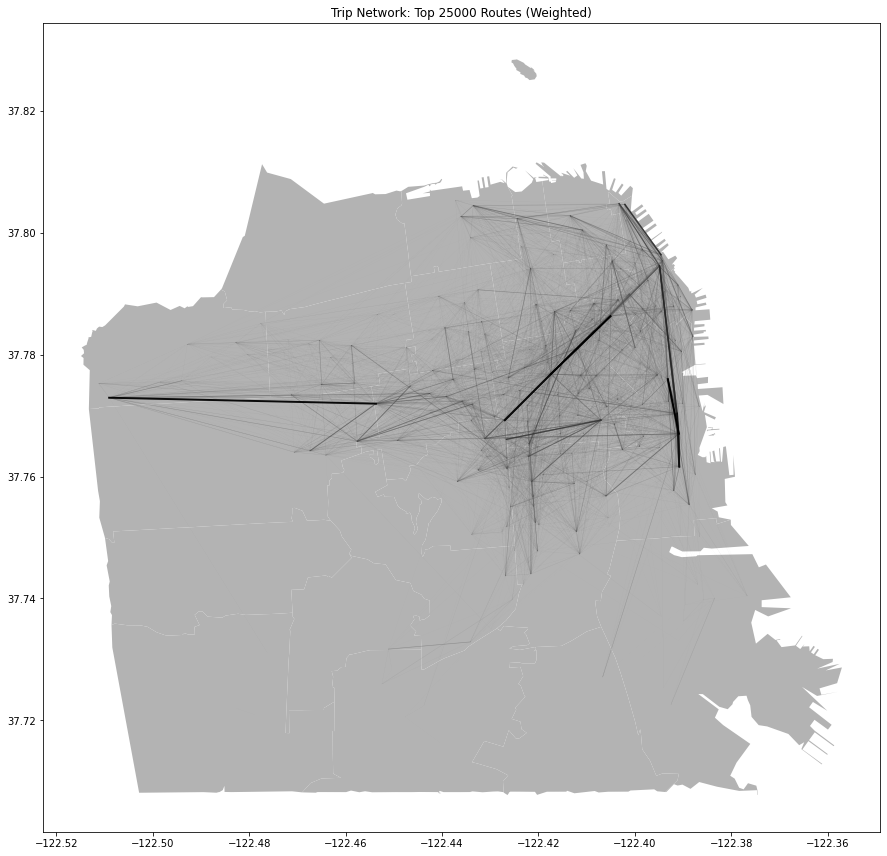

In [11]:
CRS_PLOT = 'EPSG:4326'

def plot_map(fig, ax, zips_gdf):
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color=str(0.7), zorder=0)
    
def plot_network(fig, ax, stations_gdf, edges, title=''):
    for i, edge in edges.iterrows():
        lat1, lng1, lat2, lng2 = edge[['lat1', 'lng1', 'lat2', 'lng2']]
        # 0.0 = black, 1.0 = white, flip and scale to [0.0, 0.5].
        color = (1 - edge['value']) * 0.5
        alpha = edge['value']
        linewidth = edge['value'] * 2
        ax.plot([lng1, lng2], [lat1, lat2],
                 'k-',
                 linewidth=linewidth,
                 color=str(color),
                 alpha=alpha,
                 zorder=1)

    ax.set_title(title)

N = 25000
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:],
             'Trip Network: Top {} Routes (Weighted)'.format(N))
plt.show()

In [12]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index('station_id')
    matrix.columns = matrix.columns.astype('str')
    matrix.index = matrix.index.astype('str')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df

trip_flow_df = get_flow_df(config.trip_count_matrix_path)

In [151]:
zips_gdf, stations_gdf = load_gdfs(config)
stations_flow_gdf = pd.merge(stations_gdf, trip_flow_df, on='station_id')

def plot_stations(fig, ax, stations_gdf, column, title, top_n=None, bottom_n=None):
    all_gdf = stations_gdf.to_crs({'init': CRS_PLOT}).copy()
    
    gdfs = []
    if top_n or bottom_n:
        all_gdf = all_gdf.sort_values([column], ascending=False)
        if top_n:
            gdfs.append(all_gdf.iloc[0:top_n, :])
        if bottom_n:
            gdfs.append(all_gdf.iloc[-bottom_n:, :])
    else:
        gdfs.append(all_gdf)
        
    gdf = pd.concat(gdfs)
    gdf.plot(ax=ax,
             column=column,
             norm=matplotlib.colors.Normalize(),
             cmap='coolwarm_r',
             edgecolors='black',
             zorder=2)
    ax.set_title(title)
    
    return fig, ax

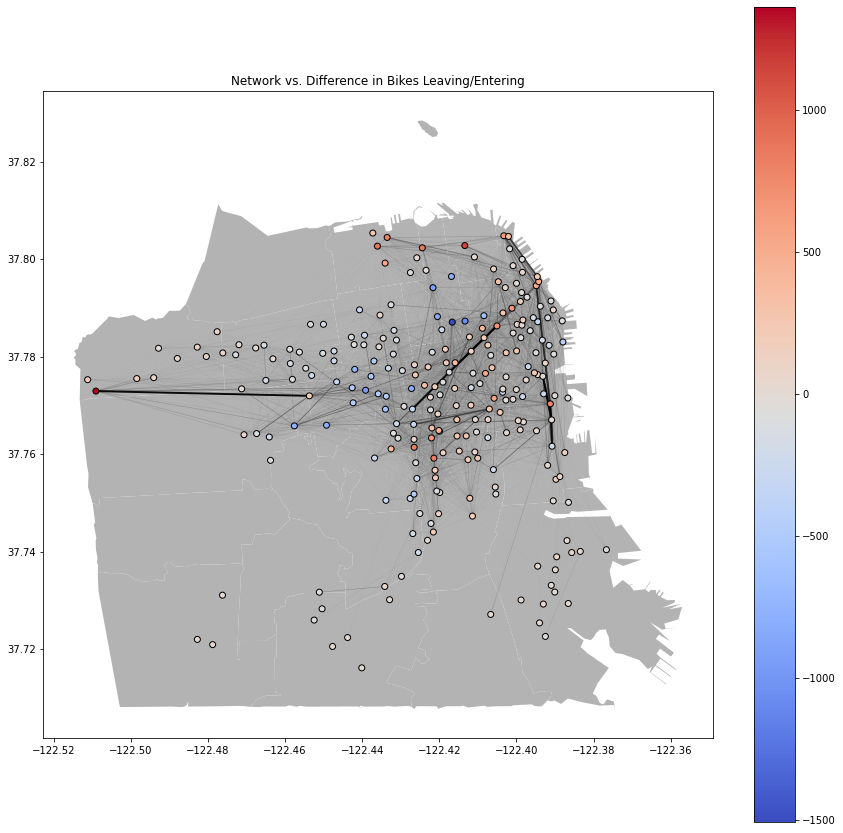

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'diff',
              'Network vs. Difference in Bikes Leaving/Entering')
plt.show()

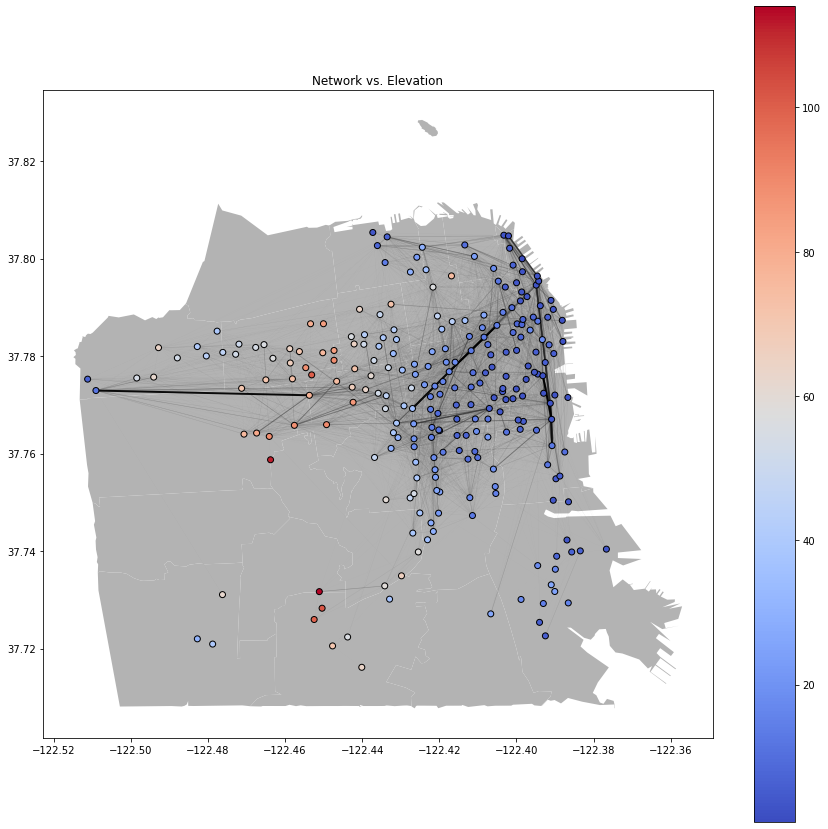

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'elevation', 'Network vs. Elevation')
plt.show()

In [22]:
config = config_dc
trip_matrix = get_trip_matrix(config)
display(trip_matrix)

,31267,31298,31250,31224,31221,31285,31213,31212,31239,31257,...,31823,31813,31818,31811,31806,31817,31816,31824,31800,31261
station_id,,,,,,,,,,,,,,,,,,,,,
31267,342,10,31,14,22,26,217,57,21,28,...,0,1,0,0,0,0,0,0,0,5
31298,13,204,19,14,23,8,19,42,23,52,...,0,0,0,0,0,0,0,0,0,6
31250,35,30,160,21,21,27,18,31,4,45,...,0,0,1,0,0,0,0,0,0,4
31224,12,20,18,94,22,14,34,30,7,17,...,0,0,0,0,0,0,0,0,0,5
31221,24,18,15,30,133,20,23,81,15,31,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31817,0,0,0,0,0,0,0,0,0,0,...,0,18,14,14,4,165,28,14,10,0
31816,0,0,0,0,0,0,0,0,0,0,...,1,13,35,8,25,33,261,15,4,0
31824,0,0,0,0,0,0,0,0,0,0,...,1,3,32,0,5,64,16,116,0,0


In [23]:
zips_gdf, stations_gdf, = load_gdfs(config)
trip_matrix_norm = normalize_matrix(trip_matrix)
edges = get_lat_lng_edges(trip_matrix_norm)

In [24]:
sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
print(len(sorted_edges))

58526


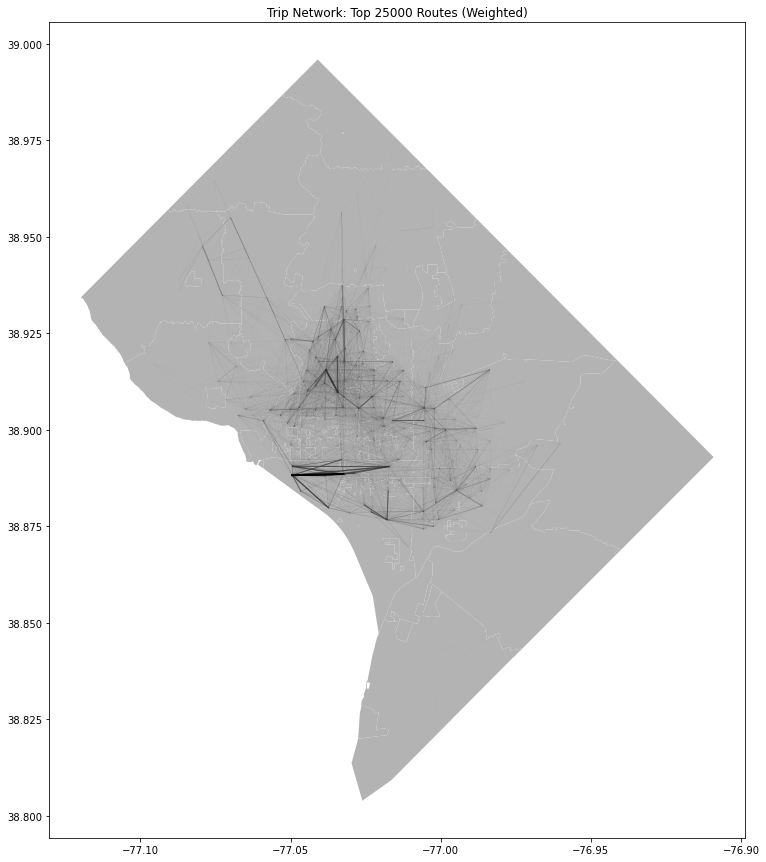

In [25]:
N = 25000
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:],
             'Trip Network: Top {} Routes (Weighted)'.format(N))
plt.show()

In [26]:
trip_flow_df = get_flow_df(config.trip_count_matrix_path)
zips_gdf, stations_gdf = load_gdfs(config)
stations_flow_gdf = pd.merge(stations_gdf, trip_flow_df, on='station_id')

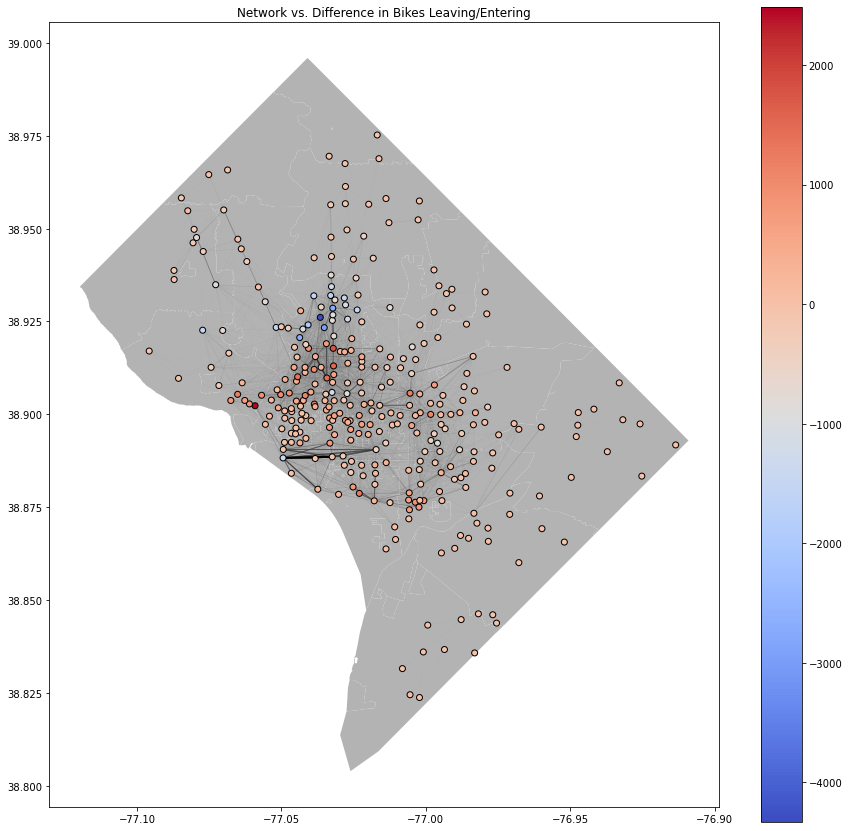

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'diff',
              'Network vs. Difference in Bikes Leaving/Entering')
plt.show()

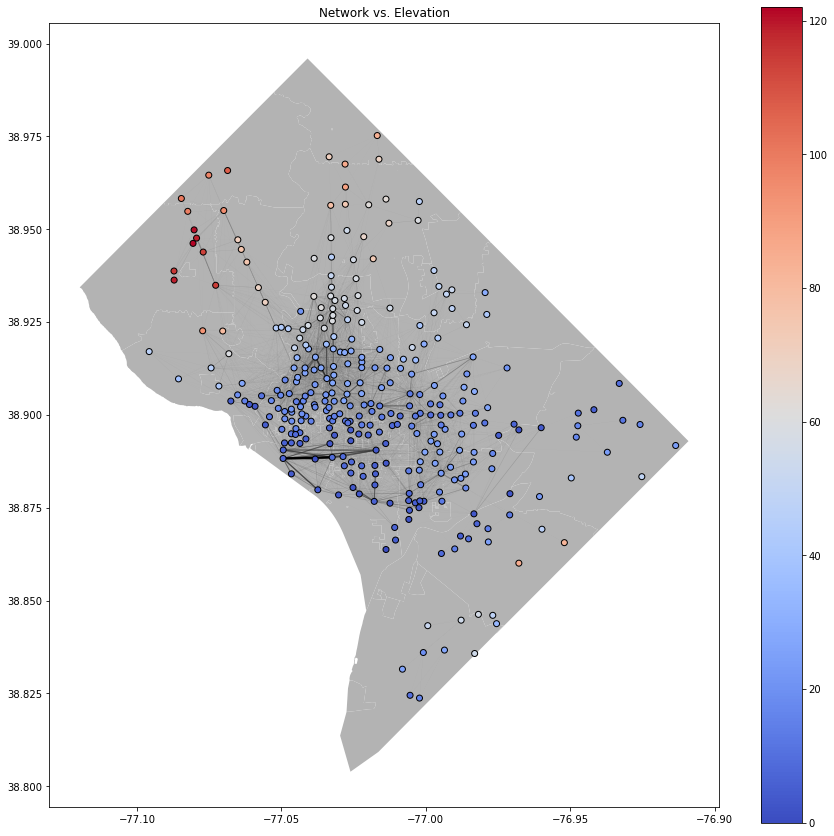

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, stations_gdf, sorted_edges[-N:])
plot_stations(fig, ax, stations_flow_gdf, 'elevation', 'Network vs. Elevation')
plt.show()

In [188]:
from enum import Enum

class Segment(Enum):
    ALL = 0
    CLASSIC = 1
    ELECTRIC = 2

class Analysis:
    def __init__(self, config, segment):
        self.config = config
        self.segment = segment
        
    def analyze(self):
        trip_matrix = get_trip_matrix(self.config, self.get_trip_count_matrix_path())
        trip_matrix = normalize_matrix(trip_matrix)
        self.trip_matrix = trip_matrix
        
        trip_flow_df = get_flow_df(self.get_trip_count_matrix_path())
        self.zips_gdf, self.stations_gdf = load_gdfs(self.config)
        self.stations_flow_gdf = pd.merge(self.stations_gdf, trip_flow_df, on='station_id')
        
        edges = get_lat_lng_edges(trip_matrix, self.stations_flow_gdf)
        edges = edges[edges['value'] > 0].sort_values(by='value')
        edges['value'] = edges['value'] / edges['value'].max()
        self.edges = edges
        
    def plot(self, fig, ax, variable=None, N=5000, top_n=None, bottom_n=None):
        plot_map(fig, ax, self.zips_gdf)
        plot_network(fig, ax, self.stations_gdf, self.edges[-N:])
        
        if variable:
            plot_stations(fig, ax, self.stations_flow_gdf, variable, self.get_plot_label(), top_n=top_n, bottom_n=bottom_n)
            
        ax.set_xticks([])
        ax.set_yticks([])
        
    def get_plot_label(self):
        if self.segment == Segment.ALL:
            return 'All'
        elif self.segment == Segment.CLASSIC:
            return 'Classic'
        elif self.segment == Segment.ELECTRIC:
            return 'Electric'
        return None
        
    def get_trip_count_matrix_path(self):
        if self.segment == Segment.ALL:
            return self.config.trip_count_matrix_path
        elif self.segment == Segment.CLASSIC:
            return self.config.trip_count_classic_matrix_path
        elif self.segment == Segment.ELECTRIC:
            return self.config.trip_count_electric_matrix_path
        return None

In [189]:
config = config_sf
analyses = [Analysis(config, s) for s in [Segment.CLASSIC, Segment.ELECTRIC]]

for analysis in analyses:
    analysis.analyze()

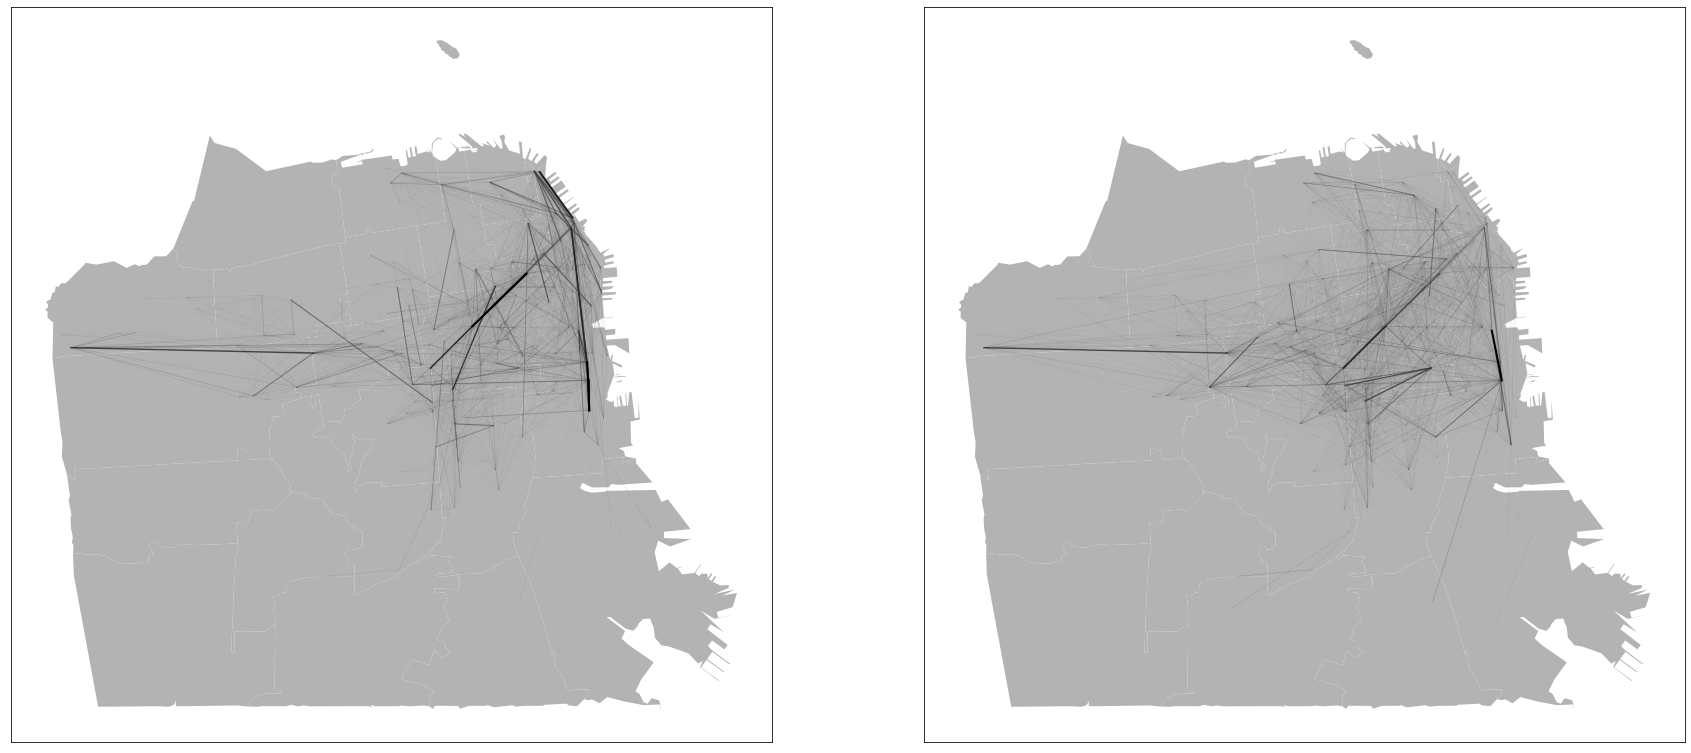

In [190]:
fig, ax = plt.subplots(1, len(analyses), figsize=(30, 15))
for i in range(0, len(analyses)):
    analyses[i].plot(fig, ax[i])

plt.show()

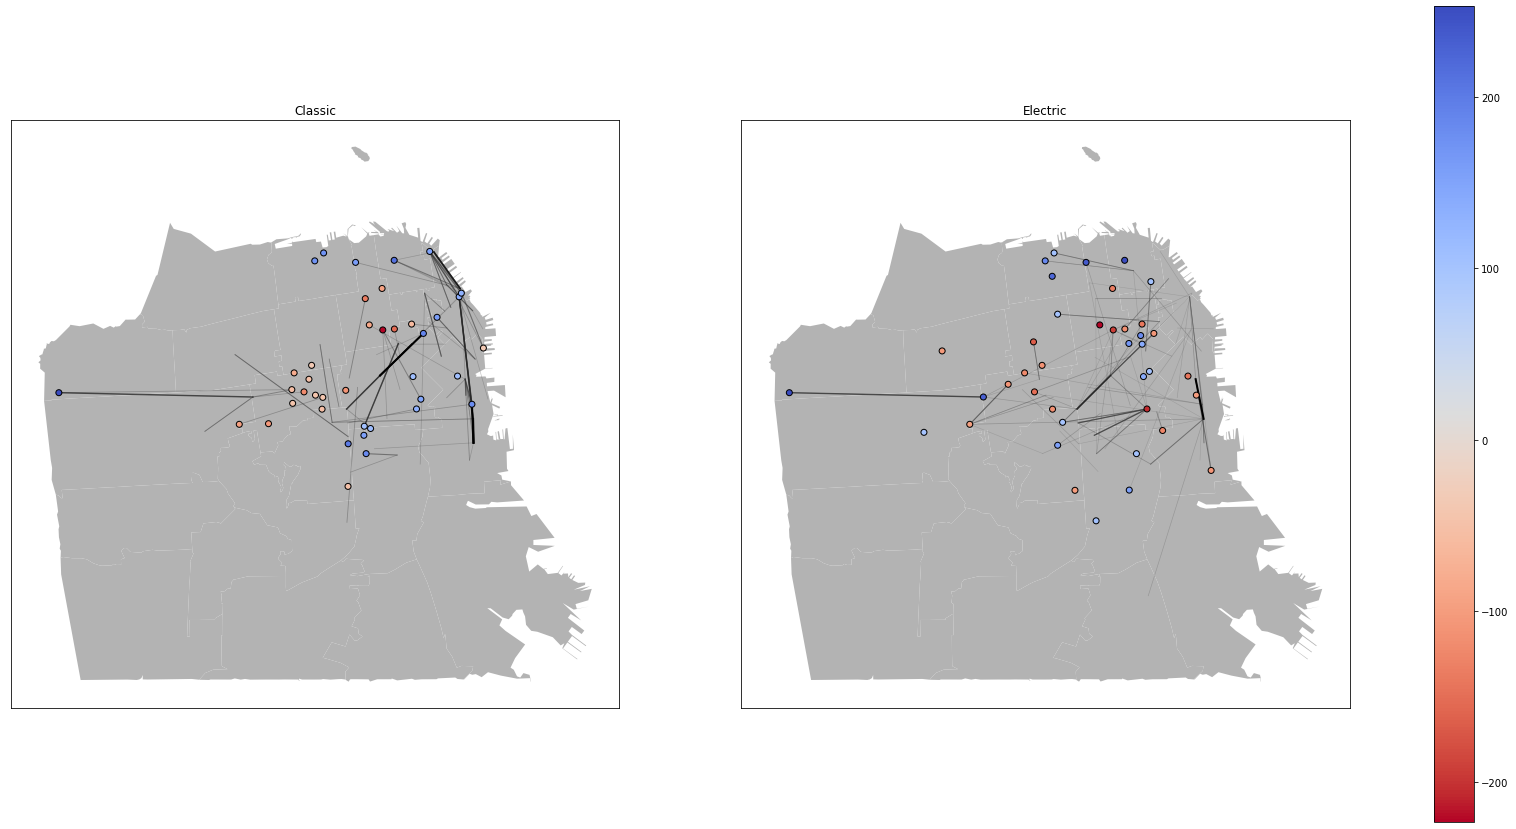

In [191]:
fig, ax = plt.subplots(1, len(analyses), figsize=(30, 15))
for i in range(0, len(analyses)):
    analyses[i].plot(fig, ax[i], 'diff', N=100, top_n=20, bottom_n=20)
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

In [201]:
def get_trips_from_matrix(matrix):
    station_ids = list(matrix.columns)
    data = []
    for id1 in station_ids:
        for id2 in station_ids:
            if id1 != id2:
                data.append({
                    'station_id1': id1,
                    'station_id2': id2,
                    'value': matrix[id1][id2],
                })
    return pd.DataFrame(data)

trip_matrix = get_trip_matrix(config)
trips_df = get_trips_from_matrix(trip_matrix)

a = analyses[0]
trip_matrix = get_trip_matrix(a.config, a.config.trip_count_classic_matrix_path)
trips_classic_df = get_trips_from_matrix(trip_matrix)

a = analyses[1]
trip_matrix = get_trip_matrix(a.config, a.config.trip_count_electric_matrix_path)
trips_electric_df = get_trips_from_matrix(trip_matrix)

merged_df = pd.merge(trips_df, trips_classic_df, on=['station_id1', 'station_id2'])
merged_df = pd.merge(merged_df, trips_electric_df, on=['station_id1', 'station_id2'])

trip_ratios_df = merged_df.rename(columns={
    'value_x': 'all',
    'value_y': 'classic',
    'value': 'electric',
})
trip_ratios_df = trip_ratios_df[trip_ratios_df['all'] > 0]

trip_ratios_df['classic_ratio'] = trip_ratios_df['classic'] / trip_ratios_df['all']
trip_ratios_df['electric_ratio'] = trip_ratios_df['electric'] / trip_ratios_df['all']

display(trip_ratios_df)


,station_id1,station_id2,all,classic,electric,classic_ratio,electric_ratio
0,SF-M26,SF-M25,3,3,0,1.000000,0.000000
1,SF-M26,SF-M26-2,9,8,1,0.888889,0.111111
3,SF-M26,SF-K26,9,9,0,1.000000,0.000000
4,SF-M26,SF-J27,4,4,0,1.000000,0.000000
5,SF-M26,SF-M30,11,4,7,0.363636,0.636364
...,...,...,...,...,...,...,...
63743,SF-Y25,SF-V31,1,0,1,0.000000,1.000000
63745,SF-Y25,SF-U30,2,0,2,0.000000,1.000000
63746,SF-Y25,SF-W14,3,0,3,0.000000,1.000000
63750,SF-Y25,SF-BB17,2,2,0,1.000000,0.000000


In [214]:
elevation_matrix_path = '{}/elevation_sf.csv'.format(MATRIX_DIR)
elevation_matrix = get_trip_matrix(config, elevation_matrix_path)
elevation_df = get_trips_from_matrix(elevation_matrix)

displacement_matrix_path = '{}/displacement_sf.csv'.format(MATRIX_DIR)
displacement_matrix = get_trip_matrix(config, displacement_matrix_path)
displacement_df = get_trips_from_matrix(displacement_matrix)

combined_trip_ratios_df = pd.merge(trip_ratios_df, elevation_df, on=['station_id1', 'station_id2'], how='left').rename(columns={'value': 'elevation_change'})
combined_trip_ratios_df = pd.merge(combined_trip_ratios_df, displacement_df, on=['station_id1', 'station_id2'], how='left').rename(columns={'value': 'displacement'})
combined_trip_ratios_df = combined_trip_ratios_df.sort_values(['all'], ascending=False)

display(combined_trip_ratios_df)

,station_id1,station_id2,all,classic,electric,classic_ratio,electric_ratio,elevation_change,displacement
7442,SF-G27,SF-J23-1,478,316,162,0.661088,0.338912,-3.0,1515.268133
3988,SF-K29-1,SF-M30,474,142,332,0.299578,0.700422,-1.0,1012.176981
22222,SF-J1,SF-K15-,461,229,232,0.496746,0.503254,-66.0,4878.125059
24216,SF-J23-1,SF-L21,439,239,200,0.544419,0.455581,-18.0,1187.015480
34431,SF-L30-1,SF-O30,432,316,116,0.731481,0.268519,-10.0,965.532541
...,...,...,...,...,...,...,...,...,...
19434,SF-F16,SF-A27,1,0,1,0.000000,1.000000,81.0,4586.969077
9605,SF-J23-2,SF-J1,1,0,1,0.000000,1.000000,4.0,7930.966335
30073,SF-R19,SF-G11,1,0,1,0.000000,1.000000,6.0,4569.890608
9607,SF-J23-2,SF-G8,1,0,1,0.000000,1.000000,-28.0,5437.225085


In [216]:
export_df = combined_trip_ratios_df.drop(['classic_ratio', 'electric_ratio'], axis=1)
display(export_df)
export_df.to_csv('../data/exports/aggregated_trips_sf.csv', )

,station_id1,station_id2,all,classic,electric,elevation_change,displacement
7442,SF-G27,SF-J23-1,478,316,162,-3.0,1515.268133
3988,SF-K29-1,SF-M30,474,142,332,-1.0,1012.176981
22222,SF-J1,SF-K15-,461,229,232,-66.0,4878.125059
24216,SF-J23-1,SF-L21,439,239,200,-18.0,1187.015480
34431,SF-L30-1,SF-O30,432,316,116,-10.0,965.532541
...,...,...,...,...,...,...,...
19434,SF-F16,SF-A27,1,0,1,81.0,4586.969077
9605,SF-J23-2,SF-J1,1,0,1,4.0,7930.966335
30073,SF-R19,SF-G11,1,0,1,6.0,4569.890608
9607,SF-J23-2,SF-G8,1,0,1,-28.0,5437.225085
